<a href="https://colab.research.google.com/github/sidnb13/moonshots/blob/master/kernels/triton_kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import triton
import triton.language as tl

In [2]:
@triton.jit
def conv1d_loop_kernel(A, B, C, N: tl.constexpr, K: tl.constexpr):
    res = tl.zeros((N,), dtype=tl.float32)

    for i in range(N):
        offs = tl.arange(0, K)
        a_range = i + offs
        b_range = offs
        a = tl.load(A + a_range)
        b = tl.load(B + b_range)
        tl.store(C + i, tl.sum(a * b))

In [3]:
N, K   = 1024, 64
device = 'cuda'
# A is exactly length N
A = torch.randn((N,), device=device, dtype=torch.float32)
B = torch.randn((K,), device=device, dtype=torch.float32)
C = torch.empty((N,), device=device, dtype=torch.float32)

# one Triton program does the whole loop
grid = lambda META: (1,)

conv1d_loop_kernel[grid](A, B, C, N, K) # type: ignore
torch.cuda.synchronize()

# torch no-pad ⇒ valid conv ⇒ length = N-K+1
expected = torch.nn.functional.conv1d(
    A[None,None,:], B[None,None,:], padding=0
).view(-1)
# compare the first N-K+1 entries of C
assert C.shape[0] >= expected.shape[0]
assert torch.allclose(C[: expected.shape[0]], expected, atol=1e-5, rtol=1e-3)


In [4]:
@triton.jit
def conv1d_tile_kernel(A, B, C, N: tl.constexpr, K: tl.constexpr, BLOCK: tl.constexpr):
    # More efficient: launch a program per tile for vectorization
    pid = tl.program_id(0)
    offs = tl.arange(0, BLOCK)
    idx = pid * BLOCK + offs
    mask = idx < N

    window = idx[:, None] + tl.arange(0, K)[None, :]

    a = tl.load(A + window, mask[:, None]) # [BLOCK, K]
    b = tl.load(B + tl.arange(0, K)) # [K]

    c = tl.sum(a * b, axis=1)
    tl.store(C + idx, c, mask)



In [5]:
N, K   = 1024, 64
device = 'cuda'
# A is exactly length N
A = torch.randn((N,), device=device, dtype=torch.float32)
B = torch.randn((K,), device=device, dtype=torch.float32)
C = torch.empty((N,), device=device, dtype=torch.float32)

BLOCK = 32

# one Triton program does the whole loop
grid = lambda META: ((N + BLOCK - 1)//BLOCK,)

conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK) # type: ignore
torch.cuda.synchronize()

# torch no-pad ⇒ valid conv ⇒ length = N-K+1
expected = torch.nn.functional.conv1d(
    A[None,None,:], B[None,None,:], padding=0
).view(-1)
# compare the first N-K+1 entries of C
assert C.shape[0] >= expected.shape[0]
assert torch.allclose(C[: expected.shape[0]], expected, atol=1e-5, rtol=1e-3)


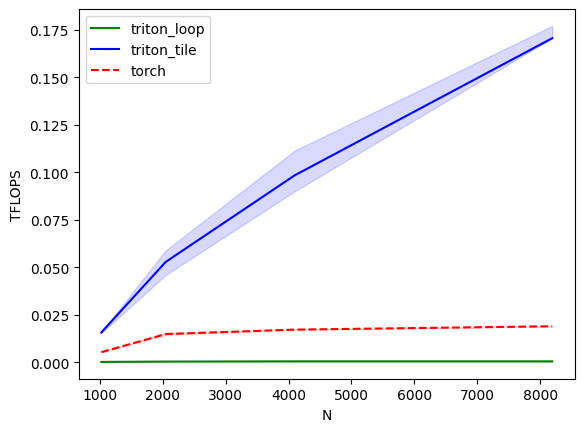

conv1d_multi:
        N  triton_loop  triton_tile     torch
0  1024.0     0.000182     0.015693  0.005333
1  2048.0     0.000366     0.052852  0.014868
2  4096.0     0.000481     0.098402  0.017192
3  8192.0     0.000483     0.170667  0.018963


In [6]:
dtype     = torch.float32
providers = ["triton_loop", "triton_tile", "torch"]
configs   = [triton.testing.Benchmark(
    x_names=["N"],
    x_vals=[2**i for i in range(10, 14)],   # 1024,2048,4096,8192
    line_arg="provider",
    line_vals=providers,
    line_names=providers,
    styles=[("green","-"),("blue","-"),("red","--")],
    ylabel="TFLOPS",
    plot_name="conv1d_multi",
    args={},                                # required
)]

@triton.testing.perf_report(configs)
def benchmark(N, provider):
    K     = 64
    BLOCK = 128
    # prepare inputs
    A = torch.randn((N,), device='cuda', dtype=dtype) / N
    B = torch.randn((K,), device='cuda', dtype=dtype) / K
    C = torch.empty_like(A)
    qs = [0.5, 0.2, 0.8]

    # pick your function based on provider
    if provider == "triton_loop":
        fn = lambda: conv1d_loop_kernel[(1,)](A, B, C, N, K)
    elif provider == "triton_tile":
        grid = lambda meta: ((N + BLOCK - 1) // BLOCK, )
        fn   = lambda: conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK)
    else:  # torch baseline
        fn = lambda: torch.nn.functional.conv1d(
            A[None,None,:], B[None,None,:], padding=K-1
        ).view(-1)

    ms, mn, mx = triton.testing.do_bench(fn, quantiles=qs)
    flops      = N * K * 2
    perf       = lambda t: flops * 1e-12 / (t * 1e-3)
    return perf(ms), perf(mx), perf(mn)

# run everything
benchmark.run(show_plots=True, print_data=True)


this only gives host-level traces

In [7]:
from torch.profiler import profile, record_function, ProfilerActivity, schedule

def export_chrome_trace_with_warmup(
    N=4096, K=64, BLOCK=128, trace_path="conv_trace.json"
):
    A = torch.randn((N,), device="cuda")/N
    B = torch.randn((K,), device="cuda")/K
    C = torch.empty_like(A)
    # warmup
    conv1d_loop_kernel[(1,)](A, B, C, N, K); torch.cuda.synchronize()
    grid = ((N + BLOCK - 1)//BLOCK,)
    conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK); torch.cuda.synchronize()
    torch.nn.functional.conv1d(
        A[None,None,:], B[None,None,:], padding=K-1
    ).view(-1); torch.cuda.synchronize()

    # record *3* regions = active=3
    prof_sched = schedule(wait=0, warmup=0, active=3, repeat=1)
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=prof_sched,
        record_shapes=True,
        with_stack=False,
        on_trace_ready=lambda p: p.export_chrome_trace(trace_path),
    ) as prof:
        with record_function("triton_loop"):
            conv1d_loop_kernel[(1,)](A, B, C, N, K)
        prof.step()

        with record_function("triton_tile"):
            conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK)
        prof.step()

        with record_function("torch_conv1d"):
            torch.nn.functional.conv1d(
                A[None,None,:], B[None,None,:], padding=K-1
            ).view(-1)
        prof.step()

    print(f"wrote chrome trace → {trace_path}")

# run it
export_chrome_trace_with_warmup()


wrote chrome trace → conv_trace.json


/usr/local/lib/python3.11/dist-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


In [15]:
@triton.jit
def softmax_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    log2_e = 1.44269504
    row_idx = pid_0 * B0 + tl.arange(0, B0)

    # find rowmax and rowsum iteratively
    rowsum = tl.zeros((B0,), dtype=tl.float32)
    rowmax = tl.zeros((B0,), dtype=tl.float32)

    for i in range(0, T, B1):
        offs = i + tl.arange(0, B1)
        x = tl.load(x_ptr + row_idx*T + offs, offs < T)
        chunk_max = tl.max(x)
        # Avoid 0 * inf -> nan error
        if i == 0:
            rowmax = tl.full((B0,), chunk_max, dtype=tl.float32)
        newmax = tl.maximum(rowmax, chunk_max)
        # Rescale all the sum terms to erase rowmax
        rowsum *= tl.exp2(log2_e * (rowmax - newmax))
        rowsum += tl.sum(tl.exp2(log2_e * (x - newmax)), 0)
        # set new max
        rowmax = newmax

    # Now normalize each chunk
    for i in range(0, T, B1):
        offs = i + tl.arange(0, B1)
        x = tl.load(x_ptr + row_idx*T + offs, offs < T)
        xnorm = tl.exp2(log2_e * (x - rowmax)) / rowsum
        tl.store(z_ptr + row_idx*T + offs, xnorm, offs < T)

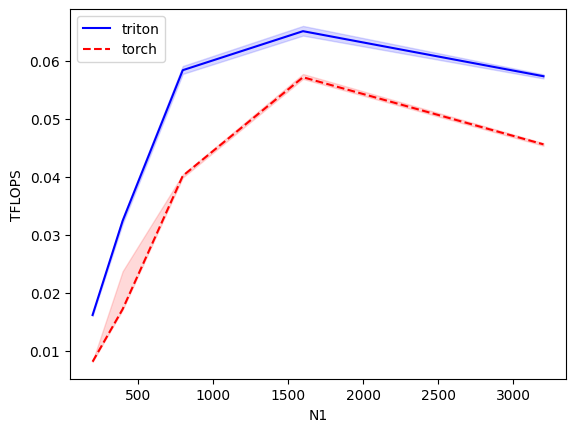

softmax_tflops:
       N1    triton     torch
0   200.0  0.016134  0.008081
1   400.0  0.032378  0.017143
2   800.0  0.058359  0.040125
3  1600.0  0.065085  0.057143
4  3200.0  0.057313  0.045565


In [20]:
import torch
import triton
import triton.testing

# pytorch reference
def softmax_spec(x):
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    return x_exp / x_exp.sum(1, keepdim=True)

# config
N0 = 256
B0 = 1
B1 = 64
providers = ["triton", "torch"]
configs = [triton.testing.Benchmark(
    x_names=["N1"],
    x_vals=[200, 400, 800, 1600, 3200],
    line_arg="provider",
    line_vals=providers,
    line_names=providers,
    styles=[("blue","-"), ("red","--")],
    ylabel="TFLOPS",
    plot_name="softmax_tflops",
    args={},
)]

@triton.testing.perf_report(configs)
def bench(N1, provider):
    x = torch.randn((N0, N1), device='cuda', dtype=torch.float32)
    y = torch.empty_like(x)
    if provider == "triton":
        grid = lambda meta: ((N0 + meta['B0'] - 1) // meta['B0'],)
        fn = lambda: softmax_kernel[grid](x, y, N0, N1, N1, B0, B1)
    else:
        fn = lambda: softmax_spec(x)
    # measure latencies
    ms, mn, mx = triton.testing.do_bench(fn, quantiles=[0.5, 0.2, 0.8])
    # ops≈6 per element (max,sub,exp,add,div)
    flops = 6 * N0 * N1
    perf = lambda t: flops * 1e-12 / (t * 1e-3)  # TFLOPS
    # return median, worst, best TFLOPS
    return perf(ms), perf(mx), perf(mn)

bench.run(show_plots=True, print_data=True)


Interpreter mode for fast and quick debugging

In [ ]:
import os
os.environ["TRITON_INTERPRET"] = "1"

import torch
import triton
import triton.language as tl

In [ ]:
def sum_spec(x):
    return x.sum(1)

@triton.jit
def sum_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    # We parallelize over the batch dim
    row_idx = pid_0 * B0 + tl.arange(0, B0)
    acc = tl.zeros((B0,), dtype=tl.float32)
    # Step in block1 size increments
    for i in range(0, T, B1):
        row_segment = i + tl.arange(0, B1)
        x = tl.load(x_ptr + row_idx*T + row_segment, row_segment < T)
        acc += tl.sum(x, 0)
    tl.store(z_ptr + row_idx, acc, row_idx < N0)

In [ ]:
from math import ceil

def test_kernel():
    B0, B1 = 1, 32
    N0, N1 = 4, 32
    T = 200
    # generate inputs
    x = torch.arange(0, T*N0, dtype=torch.float32).reshape(
        N0, T
    )
    z = torch.zeros((N0,), dtype=torch.float32)
    grid = (ceil(N0 / B0), ceil(N1 / B1))
    sum_kernel[grid](
        x_ptr=x, z_ptr=z,
        N0=N0, N1=N1, T=T,
        B0=B0, B1=B1 # type: ignore
    )
    # run ref
    z_ref = sum_spec(x)
    # compare
    print("kernel out:", z)
    print("ref out:   ", z_ref)
    print("max abs diff:", (z - z_ref).abs().max().item())

test_kernel()